In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install python_speech_features

  Created wheel for python-speech-features: filename=python_speech_features-0.6-cp37-none-any.whl size=5887 sha256=dd6d983c6476d2f5b5cd9d5ff55c15ed3bcc298635613910a57f348df6d79108
  Stored in directory: /root/.cache/pip/wheels/3c/42/7c/f60e9d1b40015cd69b213ad90f7c18a9264cd745b9888134be
Successfully built python-speech-features


In [26]:
from tensorflow import keras
from keras.layers import Dense , Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from python_speech_features import logfbank , delta
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.sequence import pad_sequences

from scipy.stats import pearsonr
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle

In [27]:
pretrained_model_path = '/content/drive/MyDrive/Grad Project/MIT/Pretrained Models/HNS-r-LSTM-layers-2-2-units-128-128-dropout-0.25_0.25_0.25_0.25.h5'

In [28]:
pretrained_model = keras.models.load_model(pretrained_model_path)
print(len(pretrained_model.layers))
pretrained_model.summary()

9
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, None, 128)         158208    
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 128)         0         
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 128)         131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 128)         0         
_________________________________________________________________
dense_1 (Dense)              (None, None, 128)         16512     
_________________________________________________________________
dropout_3 (Dropout)          (None, None, 128)         0         
_________________________________________________________________
dense_2 (Dense)              (None, None, 128)      

In [29]:
#pretrained_model.layers.pop()
#print(len(pretrained_model.layers))
#pretrained_model.summary()

In [30]:
def my_model():
  new_pretrained_model = pretrained_model #keras.Sequential(pretrained_model.layers[:-1])   #pretrained_model

  weights_path = '/content/drive/MyDrive/Grad Project/MIT/checkpoints/training_1/cp.ckpt'
  new_pretrained_model.load_weights(weights_path)
  for layer in new_pretrained_model.layers[:-1]:
    layer.trainable = False
  
  # new_pretrained_model.add(Dense(16 , activation='relu' , name='aaaa'))
  # new_pretrained_model.add(Dropout(0.25 , name = 'dddd'))
  #new_pretrained_model.add(Dense(1 , kernel_regularizer=keras.regularizers.l2(l2=0.01) , name='bbb'))
  new_pretrained_model.compile(loss='mean_squared_error' , optimizer = 'adam')#optimizer=keras.optimizers.Adam(learning_rate=0.001))
  return new_pretrained_model

In [31]:
estimator = KerasRegressor(build_fn=my_model , epochs=300 , batch_size = 32 , verbose=1 )

# Data

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav
import os
from os import path

In [33]:
cd '/content/drive/MyDrive/Grad Project/MIT/Audios_Answers'

/content/drive/MyDrive/Grad Project/MIT/Audios_Answers


In [34]:
def get_labels():
  labels_path = '/content/drive/MyDrive/Grad Project/MIT/turker_scores_full_interview.csv'
  data_frame = pd.read_csv(labels_path)
  data_frame = data_frame[data_frame['Worker'] == 'AGGR']
  return data_frame

In [35]:
def set_data(trait = 'Overall'):
  
  all_interviews = np.load('/content/drive/MyDrive/Grad Project/MIT/interview_features.npy')
  print(all_interviews.shape)
  #all_interviews = all_interviews.reshape(all_interviews.shape[0] , all_interviews.shape[1] * all_interviews.shape[2])
  #padded_array = np.zeros((all_interviews.shape[0] , 180))
  #padded_array[: , :120] = all_interviews
  #all_interviews = padded_array
  #print(all_interviews.shape)
  labels = get_labels()[trait]
  

  P_data , PP_data , P_labels , PP_labels = all_interviews[0:69 , : ] , all_interviews[69: , : ] , labels[0:69] , labels[69:]
  P_data , PP_data , P_labels , PP_labels = shuffle(P_data , PP_data , P_labels , PP_labels , random_state = 2)

  del(all_interviews)
  del(labels)

  train_data , test_data = np.concatenate((P_data[0:55 , :] , PP_data[0:55 , :])) , np.concatenate((P_data[55: , :] , PP_data[55: , :]))
  train_labels, test_labels = np.concatenate((P_labels[0:55] , PP_labels[0:55])), np.concatenate((P_labels[55:] , PP_labels[55:]))

  return train_data , test_data , train_labels , test_labels

In [36]:
def training_SVR(trait = 'Overall'):
  
  train_data , test_data , train_labels , test_labels = set_data(trait)

  train_data = train_data.reshape(train_data.shape[0] , train_data.shape[1] * train_data.shape[2])
  test_data = test_data.reshape(test_data.shape[0] , test_data.shape[1] * test_data.shape[2])

  scaler = StandardScaler()
  scaler.fit(train_data)
  train_data = scaler.transform(train_data)
  test_data = scaler.transform(test_data)

  #train_data = train_data.reshape(train_data.shape[0] , 1 , 180)
  #test_data = test_data.reshape(test_data.shape[0] , 1, 180)

  train_data = train_data.reshape(train_data.shape[0] , 2500 , 180)
  test_data = test_data.reshape(test_data.shape[0] , 2500, 180)
  
  val_data , val_labels = test_data[:14 ,:] , test_labels[:14]
  #test_data , test_labels = test_data[14: ,:] , test_labels[14:]

  #param_grid = [{'kernel': ['linear' , 'rbf']}]
  #params = {'batch_size': [16 , 32]} 
  #        'epochs': [50, 100]}

  grids = estimator
  #grids = GridSearchCV(estimator , params,cv=10)

  checkpoint_path = '/content/drive/MyDrive/Grad Project/MIT/checkpoints/training_1/cp.ckpt'
  checkpoint_dir = os.path.dirname(checkpoint_path)

  cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1 , save_best_only = True)

  # Train the model with the new callback
  grids.fit(train_data, 
          train_labels,  
          epochs=500,
          validation_data=(val_data, val_labels),
          callbacks=[cp_callback])  # Pass callback to training



  #grids.fit(train_data , train_labels) #, validation_data = (val_data , val_labels))
  #print(grids.score(test_data , test_labels))
  Y_predicted = grids.predict(test_data)
  Y_predicted = np.mean(Y_predicted , axis=1)
  correlation_res , _ = pearsonr(Y_predicted , test_labels)
  print('--------------------------------' + trait + '--------------------------------')
  print(correlation_res)
  print(test_labels)
  print(Y_predicted)

  plt.scatter(Y_predicted , test_labels)

  return grids  

In [ ]:
training_SVR('Friendly')

(138, 2500, 180)
Epoch 1/500
4/4 [==============================] - 37s 8s/step - loss: 17.7546 - val_loss: 16.9789

Epoch 00001: val_loss improved from inf to 16.97892, saving model to /content/drive/MyDrive/Grad Project/MIT/checkpoints/training_1/cp.ckpt
Epoch 2/500
4/4 [==============================] - 33s 8s/step - loss: 17.2207 - val_loss: 16.7240

Epoch 00002: val_loss improved from 16.97892 to 16.72404, saving model to /content/drive/MyDrive/Grad Project/MIT/checkpoints/training_1/cp.ckpt
Epoch 3/500
4/4 [==============================] - 33s 8s/step - loss: 16.7424 - val_loss: 16.5211

Epoch 00003: val_loss improved from 16.72404 to 16.52107, saving model to /content/drive/MyDrive/Grad Project/MIT/checkpoints/training_1/cp.ckpt
Epoch 4/500
4/4 [==============================] - 34s 9s/step - loss: 16.2989 - val_loss: 16.3650

Epoch 00004: val_loss improved from 16.52107 to 16.36499, saving model to /content/drive/MyDrive/Grad Project/MIT/checkpoints/training_1/cp.ckpt
Epoch 5/

(138, 2500, 180)
Epoch 1/500
4/4 [==============================] - 28s 6s/step - loss: 7.6664 - val_loss: 6.4749

Epoch 00001: val_loss improved from inf to 6.47492, saving model to /content/drive/MyDrive/Grad Project/MIT/checkpoints/training_1/cp.ckpt
Epoch 2/500
4/4 [==============================] - 20s 5s/step - loss: 7.6460 - val_loss: 6.4564

Epoch 00002: val_loss improved from 6.47492 to 6.45641, saving model to /content/drive/MyDrive/Grad Project/MIT/checkpoints/training_1/cp.ckpt
Epoch 3/500
4/4 [==============================] - 19s 5s/step - loss: 7.5935 - val_loss: 6.4393

Epoch 00003: val_loss improved from 6.45641 to 6.43927, saving model to /content/drive/MyDrive/Grad Project/MIT/checkpoints/training_1/cp.ckpt
Epoch 4/500
4/4 [==============================] - 19s 5s/step - loss: 7.5887 - val_loss: 6.4207

Epoch 00004: val_loss improved from 6.43927 to 6.42066, saving model to /content/drive/MyDrive/Grad Project/MIT/checkpoints/training_1/cp.ckpt
Epoch 5/500
4/4 [======

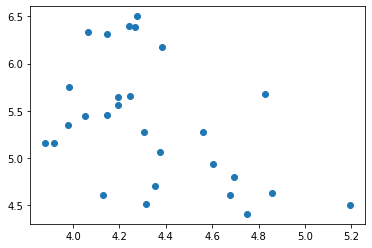

In [13]:
training_SVR('Friendly')

(138, 2500, 180)
Epoch 1/500
4/4 [==============================] - 34s 5s/step - loss: 2.5961 - val_loss: 1.9465

Epoch 00001: val_loss improved from inf to 1.94651, saving model to /content/drive/MyDrive/Grad Project/MIT/checkpoints/training_1/cp.ckpt
Epoch 2/500
4/4 [==============================] - 21s 5s/step - loss: 2.5939 - val_loss: 1.9339

Epoch 00002: val_loss improved from 1.94651 to 1.93390, saving model to /content/drive/MyDrive/Grad Project/MIT/checkpoints/training_1/cp.ckpt
Epoch 3/500
4/4 [==============================] - 21s 5s/step - loss: 2.5941 - val_loss: 1.9241

Epoch 00003: val_loss improved from 1.93390 to 1.92410, saving model to /content/drive/MyDrive/Grad Project/MIT/checkpoints/training_1/cp.ckpt
Epoch 4/500
4/4 [==============================] - 21s 5s/step - loss: 2.5802 - val_loss: 1.9175

Epoch 00004: val_loss improved from 1.92410 to 1.91754, saving model to /content/drive/MyDrive/Grad Project/MIT/checkpoints/training_1/cp.ckpt
Epoch 5/500
4/4 [======

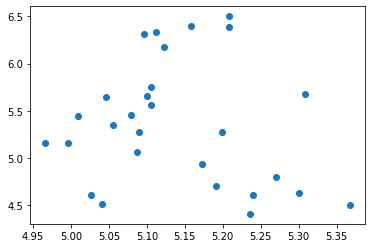

In [25]:
training_SVR('Friendly')

(138, 2500, 180)
Epoch 1/500
4/4 [==============================] - 34s 5s/step - loss: 0.7281 - val_loss: 0.5145

Epoch 00001: val_loss improved from inf to 0.51455, saving model to /content/drive/MyDrive/Grad Project/MIT/checkpoints/training_1/cp.ckpt
Epoch 2/500
4/4 [==============================] - 21s 5s/step - loss: 0.7225 - val_loss: 0.5176

Epoch 00002: val_loss did not improve from 0.51455
Epoch 3/500
4/4 [==============================] - 21s 5s/step - loss: 0.7234 - val_loss: 0.5127

Epoch 00003: val_loss improved from 0.51455 to 0.51268, saving model to /content/drive/MyDrive/Grad Project/MIT/checkpoints/training_1/cp.ckpt
Epoch 4/500
4/4 [==============================] - 21s 5s/step - loss: 0.7207 - val_loss: 0.5064

Epoch 00004: val_loss improved from 0.51268 to 0.50638, saving model to /content/drive/MyDrive/Grad Project/MIT/checkpoints/training_1/cp.ckpt
Epoch 5/500
4/4 [==============================] - 21s 5s/step - loss: 0.7161 - val_loss: 0.5099

Epoch 00005: val_

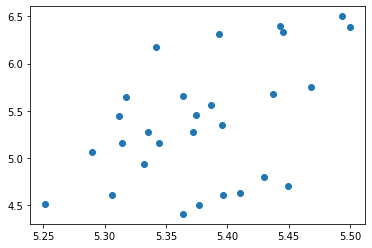

In [37]:
training_SVR('Friendly')

In [ ]:
training_SVR('Overall')

(138, 40, 3)
(138, 180)
Epoch 1/500
4/4 [==============================] - 4s 5ms/step - loss: 11.8920
Epoch 2/500
4/4 [==============================] - 0s 6ms/step - loss: 9.8413
Epoch 3/500
4/4 [==============================] - 0s 4ms/step - loss: 9.3959
Epoch 4/500
4/4 [==============================] - 0s 5ms/step - loss: 8.6160
Epoch 5/500
4/4 [==============================] - 0s 5ms/step - loss: 8.5666
Epoch 6/500
4/4 [==============================] - 0s 5ms/step - loss: 7.3743
Epoch 7/500
4/4 [==============================] - 0s 5ms/step - loss: 6.5633
Epoch 8/500
4/4 [==============================] - 0s 5ms/step - loss: 6.2771
Epoch 9/500
4/4 [==============================] - 0s 5ms/step - loss: 5.4526
Epoch 10/500
4/4 [==============================] - 0s 5ms/step - loss: 4.5625
Epoch 11/500
4/4 [==============================] - 0s 6ms/step - loss: 4.2340
Epoch 12/500
4/4 [==============================] - 0s 7ms/step - loss: 3.6771
Epoch 13/500
4/4 [==================